# Analysis of Newborn Names in the United States

#####  By Messiah Ataey. Data extracted from the United States Social Security Administration for the years 1880-2019. Adapted from Wes McKinney.

In [1]:
# Standard package imports and configurations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('darkgrid')

In [2]:
# Check contents of a single csv file representing a specific year (e.g. 1950)

sample = pd.read_csv(r'H:\messiah\resources\programming\datasets\names\yob1950.txt', names=['name', 'sex', 'births'])
sample.head()

,name,sex,births
0,Linda,F,80433
1,Mary,F,65478
2,Patricia,F,47944
3,Barbara,F,41553
4,Susan,F,38017


In [3]:
# Concatenate all adjacent csv files into a single DataFrame

years = range(1880, 2019+1)
file_parts = []
columns = ['name', 'sex', 'births']

for year in years: 
    path = r'H:\messiah\resources\programming\datasets\names\yob{0}.txt'.format(year)
    frame = pd.read_csv(path, names=columns)
    frame['year'] = year
    file_parts.append(frame)
    
names = pd.concat(file_parts, ignore_index=True)

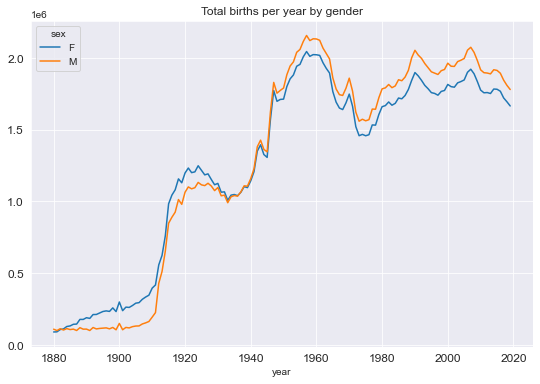

In [4]:
# Plot total births per year by gender

total_births = names.groupby(['year', 'sex']).births.sum().unstack()
total_births.plot(title='Total births per year by gender', figsize=(9, 6), kind='line', fontsize=12)

In [5]:
# Construct a new column containing the proportion of each name per year

def proportion(group):
    group['proportion'] = group['births'] / group['births'].sum()
    return group
names = names.groupby(['year', 'sex']).apply(proportion)

In [6]:
# Extract only the top 1000 names per year; drop index values

def extract_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]
grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(extract_top1000)
top1000.reset_index(inplace=True, drop=True)
top1000.head()

,name,sex,births,year,proportion
0,Mary,F,7065,1880,0.077642
1,Anna,F,2604,1880,0.028617
2,Emma,F,2003,1880,0.022012
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188


In [7]:
# Partition top 1000 subset by gender into two seperate DataFrames

boys = top1000[top1000.sex == 'M']
girls = top1000[top1000.sex == 'F']

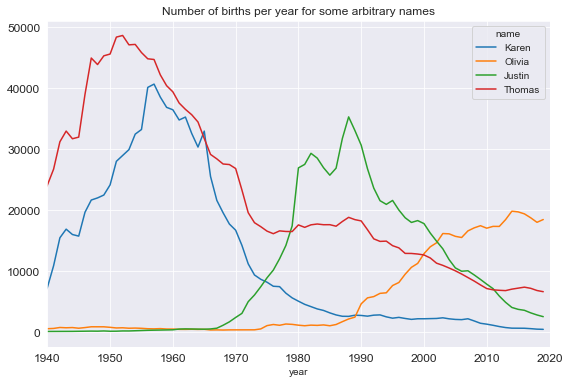

In [8]:
# Plot the total births per year by name for some arbitrary names from 1940 onwards

total_births = top1000.pivot_table('births', index='year', columns='name', aggfunc=sum)
total_births[['Karen', 'Olivia', 'Justin', 'Thomas', ]].plot(title='Number of births per year for some arbitrary names', figsize=(9,6), kind='line', subplots=False, xlim=(1940, 2019+1), fontsize=12)

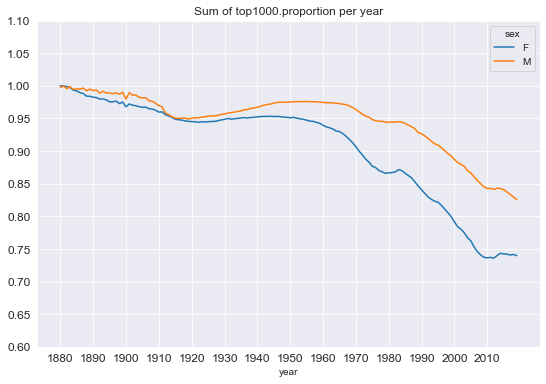

In [9]:
# Plot the sum of the proportion of the top 1000 names per year as a means of measuring name diversity over time

table = top1000.pivot_table('proportion', index='year', columns='sex', aggfunc=sum)
table.plot(title='Sum of top1000.proportion per year', figsize=(9,6), yticks=np.linspace(0.6, 1.1, 11), xticks=range(1880, 2019+1, 10), fontsize=12)

In [10]:
''' Evaluate and plot the 50% quantile count for the top 1000 names for each 
    year as an alternative method of measuring name diversity '''

def quantile_count(group, q=0.5):
    group = group.sort_values(by='proportion', ascending=False)
    return group.proportion.cumsum().values.searchsorted(q) + 1

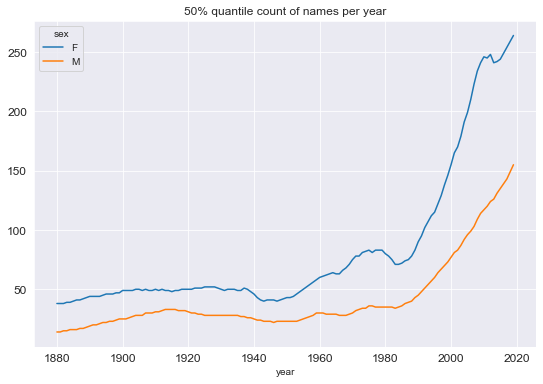

In [11]:
diversity = top1000.groupby(['year', 'sex']).apply(quantile_count).unstack('sex')
diversity.plot(title='50% quantile count of names per year', figsize=(9,6), fontsize=12)

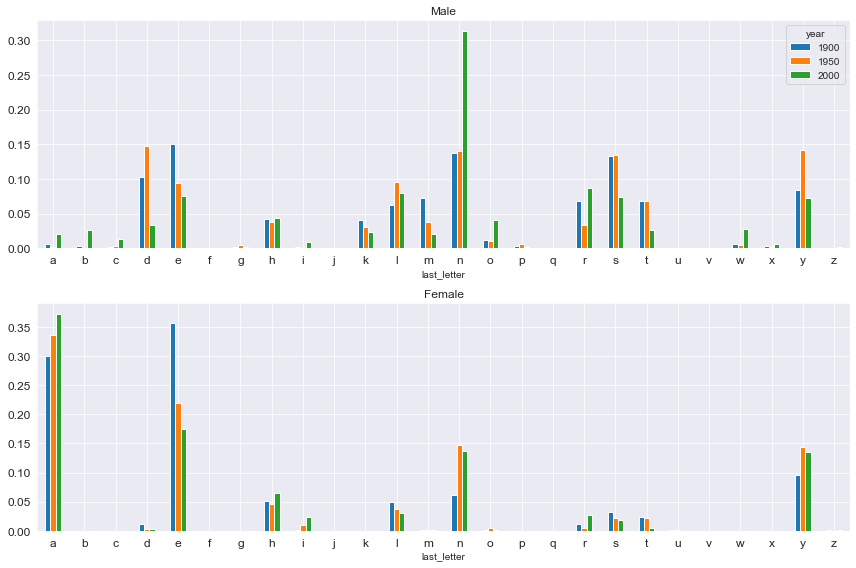

In [12]:
# Analyze trends in the last letters of names over time

last_letters = names.name.map(lambda x: x[-1])
last_letters.name = 'last_letter'

# Plot the proportion of last letters in names for some arbitrary years throughout history

table = names.pivot_table('births', index=last_letters, columns=['sex', 'year'], aggfunc=sum)
subset = table.reindex(columns=[1900, 1950, 2000], level='year')
letter_prop = subset / subset.sum()

fig, axes = plt.subplots(2, 1, figsize=(12,8))
letter_prop['M'].plot(kind='bar', ax=axes[0], title='Male', legend=True, rot=0, fontsize=12)
letter_prop['F'].plot(kind='bar', ax=axes[1], title='Female', legend=False, rot=0, fontsize=12)
fig.tight_layout()

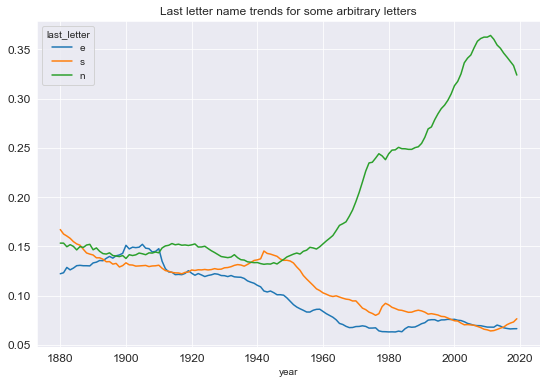

In [13]:
# Plot some arbitrary last letters from names over time

letter_prop = table / table.sum()
esn_ts = letter_prop.loc[['e', 's', 'n'], 'M'].T
esn_ts.plot(title='Last letter name trends for some arbitrary letters', figsize=(9,6), fontsize=12)

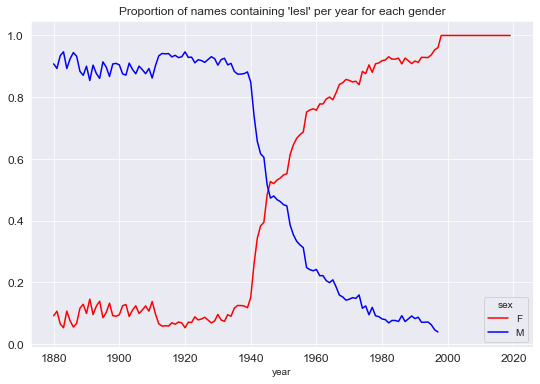

In [14]:
''' Plot the trend of names containing 'Lesl' (e.g. Leslie, Leslee, Lesli, etc.) to see changing preferences 
    by gender with these names over time '''

every_name = pd.Series(top1000.name.unique())
lesl_names = every_name[every_name.str.lower().str.contains('lesl')]
new_names = top1000[top1000.name.isin(lesl_names)]
new_names.groupby('name').births.sum()

table = new_names.pivot_table('births', index='year', columns='sex', aggfunc=sum)
table = table.div(table.sum(1), axis=0)
table.plot(title="Proportion of names containing 'lesl' per year for each gender", style={'M': 'b-', 'F': 'r-'}, figsize=(9,6), fontsize=12)